In [251]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("pastel")

# Key metrics for driver engagement

In [238]:
df_drivers = pd.read_csv('x_drivers.csv')

In [239]:
df_activity = pd.read_csv('x_drivers_activity.csv')

**1. x_drivers**
-  Id_driver: the driver ID
- Date_registration: the date when the user was activated
- Driver_rating: the average rating of the driver last 100 rides
- Gold_level_count: amount of times the driver reached gold status meaning they were among the top performers in a specific week
- Receive_marketing: Takes one of two values, True if the driver accepted to receive marketing and campaign communications and False, if not
- Country_code: Country where the user operates
- Service_type: If the user is TAXI or a Private Hire Vehicle (PHV)
    
    
**2. x_drivers_activity**
- Id_driver: the driver ID
- Active_date: date when the user operated in the platform
- Offers: number of requests for a ride that a driver received
- Bookings: number of requests accepted by the driver
- Bookings_cancelled_by_passenger: number of requests accepted by the driver and then cancelled by the passenger, before the ride was completed
- Bookings_cancelled_by_driver: number of requests accepted by the driver and then cancelled by the driver, before the ride was completed
- Rides: number of rides completed by the driver

In [240]:
df_drivers.head()

,id_driver,date_registration,driver_rating,gold_level_count,receive_marketing,country_code,service_type
0,15260831,2015-11-18,4.850,2.000,True,ES,TAXI
1,58194598,2020-03-12,4.790,26.000,True,DE,PHV
2,21139412,2017-05-15,4.760,10.000,True,DE,TAXI
3,48382094,2019-03-20,4.910,3.000,False,DE,TAXI
4,52914047,2019-08-02,4.960,10.000,True,DE,PHV


## How to monitor over time Driver’s engagement?

In [241]:
df_activity = df_drivers.merge(df_activity, on='id_driver', how='inner')

In [242]:
df_activity.loc[df_activity.active_date.isnull()]

,id_driver,date_registration,driver_rating,gold_level_count,receive_marketing,country_code,service_type,active_date,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides


In [243]:
df_activity.active_date = pd.to_datetime(df_activity.active_date)
df_activity.date_registration = pd.to_datetime(df_activity.date_registration)

In [244]:
df_activity['active_y'] = df_activity.active_date.dt.isocalendar().year
df_activity['active_cw'] = df_activity.active_date.dt.isocalendar().week

df_activity['active_y'] = df_activity['active_y'].astype(str)
df_activity['active_cw'] = df_activity['active_cw'].astype(str)

In [245]:
df_activity.loc[(df_activity.date_registration.dt.isocalendar().year<2020) |
                ((df_activity.date_registration.dt.isocalendar().year==2020) &
                (df_activity.date_registration.dt.isocalendar().week<=17))].id_driver.nunique()/\
df_activity.id_driver.nunique()

0.9779717712327649

In [246]:
df_activity['active_ycw'] =  df_activity.apply( lambda x : 
        x['active_y'] + '-' +  x['active_cw']
            if len(x['active_cw'])==2 else
        x['active_y'] + '-0' +  x['active_cw'], axis=1)

In [247]:
df_activity['perc_canc_driver_booking'] = (df_activity.bookings_cancelled_by_driver/df_activity.bookings)*100
df_activity['perc_ride_offer'] = (df_activity.rides/df_activity.offers)*100

In [285]:
def extract_metrics(driver_ycw_level=['active_ycw', 'id_driver'], ycw_level=['active_ycw']):

    df_engagement = df_activity.groupby(driver_ycw_level).agg(
     perc_canc_driver = ('perc_canc_driver_booking', 'mean')
     , rides = ('rides', 'sum')
    ).reset_index()
    
    df_engagement = df_engagement.replace(np.inf, np.nan)
    
    df_cw_engagement = df_engagement.groupby(ycw_level).agg(
       perc_canc_driver =  ('perc_canc_driver', 'mean')
     , cnt_drivers =  ('id_driver', 'nunique')
     , rides = ('rides', 'mean')).reset_index()
    
    return df_cw_engagement

In [286]:
df_cw_engagement = extract_metrics()

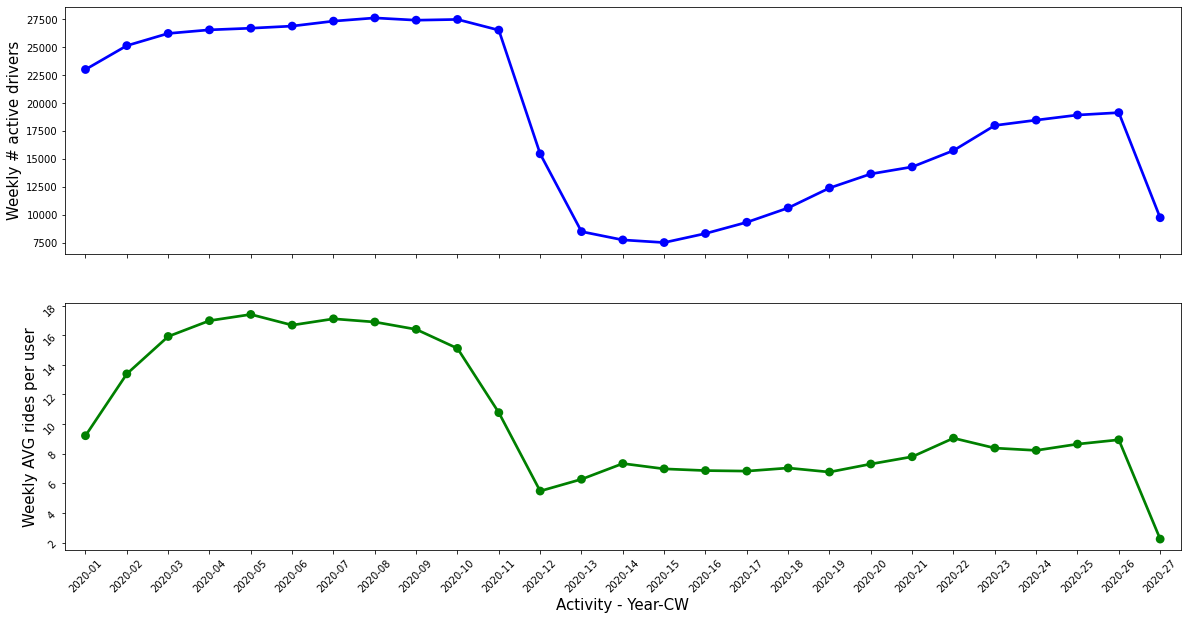

In [294]:
f, axes = plt.subplots(2, 1, figsize=(20,10))
sns.pointplot(x="active_ycw", y="cnt_drivers", data=df_cw_engagement, ax=axes[0], color='blue')
axes[0].set_ylabel('Weekly # active drivers', fontsize=15)
axes[0].tick_params(axis='x')
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

sns.pointplot(x="active_ycw", y="rides", data=df_cw_engagement, ax=axes[1], color='green')
axes[1].set_ylabel('Weekly AVG rides per user', fontsize=15)
axes[1].set_xlabel('Activity - Year-CW', fontsize=15)
axes[1].tick_params(labelrotation=45)

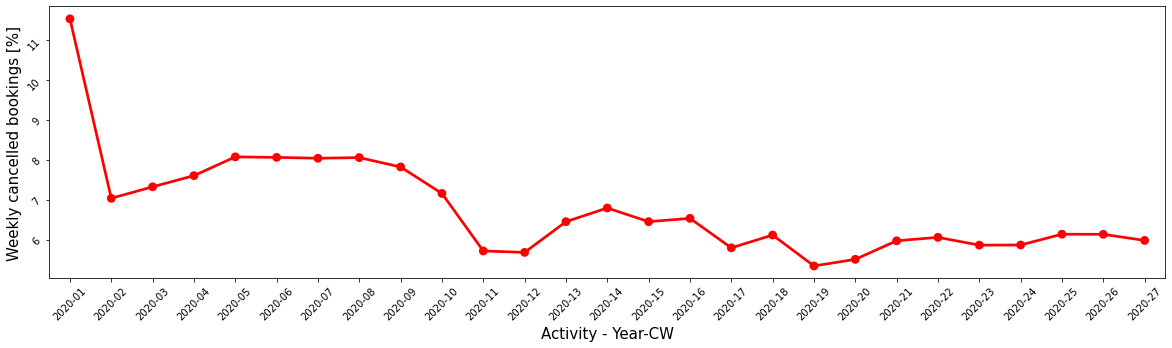

In [299]:
f, axes = plt.subplots(1, 1, figsize=(20,5))
sns.pointplot(x="active_ycw", y="perc_canc_driver", data=df_cw_engagement, ax=axes, color='red')
axes.set_ylabel('Weekly cancelled bookings [%]', fontsize=15)
axes.set_xlabel('Activity - Year-CW', fontsize=15)
axes.tick_params(labelrotation=45)

## Segments associated with driver’s engagement?

In [288]:
df_iso_stype = extract_metrics(driver_ycw_level=['id_driver', 'country_code', 'service_type']
                                   , ycw_level=['country_code', 'service_type'])

In [289]:
df_iso_stype

,country_code,service_type,perc_canc_driver,cnt_drivers,rides
0,DE,PHV,7.380,5651,249.420
1,DE,TAXI,6.456,20151,122.922
2,ES,TAXI,8.575,11170,185.197


In [291]:
df_activity.groupby(['country_code', 'service_type']).gold_level_count.describe()

count   mean    std   min   25%    50%    75%  \
country_code service_type                                                       
DE           PHV           180591.000  5.869 11.482 0.000 0.000  2.000  8.000   
             TAXI         1010615.000 26.376 32.888 0.000 2.000 12.000 40.000   
ES           TAXI          544622.000 24.157 30.872 0.000 2.000 11.000 35.000   

                              max  
country_code service_type          
DE           PHV          173.000  
             TAXI         224.000  
ES           TAXI         179.000

# A/B test on email campaign to incentivise driver activity

In [169]:
df_campaign = pd.read_csv('x_driver_campaign.csv', skiprows=1)

In [175]:
df_campaign.head()

,driver,rides_within_week,test_group
0,1,88,A
1,2,56,B
2,3,80,B
3,4,49,A
4,5,61,A


In [176]:
df_campaign.groupby('test_group').agg({'rides_within_week': ['count', 'mean']})

rides_within_week         
                       count     mean
test_group                           
A                       5000  50.0450
B                       5000  52.1168

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rides_within_week', ylabel='Density'>

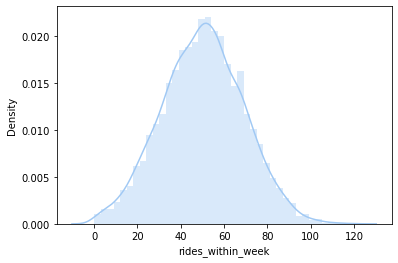

In [177]:
sns.distplot(df_campaign.loc[df_campaign.test_group=='A'].rides_within_week)

<AxesSubplot:xlabel='rides_within_week', ylabel='Density'>

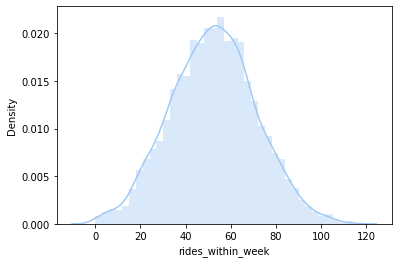

In [179]:
sns.distplot(df_campaign.loc[df_campaign.test_group=='B'].rides_within_week)

- H0: A >= B
- H1: B > A

In [189]:
alpha = 0.05

In [190]:
a = df_campaign.loc[df_campaign.test_group=='A'].rides_within_week
b = df_campaign.loc[df_campaign.test_group=='B'].rides_within_week

In [191]:
t_value, p_value = stats.ttest_ind(a,b)

In [300]:
if p_value/2 < alpha:
    print('Reject H0')
else: 
    print('Accept H0')

Reject H0


In [197]:
'%.6f' %(p_value/2)

'0.000000'